<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">22.418 · Aprenentatge automàtic</p>
<p style="margin: 0; text-align:right;">Grau en Ciència de Dades Aplicada</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudis de Informàtica, Multimèdia i Telecomunicació</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>

# CNN Transfer Learning

In this notebook we will learn how to finetune a modern
CNN architecture from the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module, which has been pretrained on the [Imagenet dataset](http://www.image-net.org/). The [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module implements lots of popular CNN models such as: VGG, ResNet, DenseNet, Inception, etc.

The Imagenet dataset has 1000 classes and millions of images. Training a ResNet-50 model on ImageNet-1k with a single GPU takes several days. The key idea of transfer learning is to reuse the knowledge learned in one task to solve a different task. Transfer learning is specially useful when we do not have lots of training data for the new task and/or when we want to speed up the training of the new model.

For the target task we will use the [hymenoptera_data dataset](https://download.pytorch.org/tutorial/hymenoptera_data.zip), which consists in only **two classes** ('ants' and 'bees') and only around **one hundred training examples** for each class.


We will perform two types of transfer learning: finetuning and feature extraction. In **finetuning**, we start with a pretrained model and update *all* of the model’s parameters for a new task. In **feature extraction**,
we start with a pretrained model and only update the final layer weights. 

In general both transfer learning methods follow the same few steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to update during training
-  Run the training step

"**Note**: If you are running this in [a colab notebook](https://colab.research.google.com/), you should install the dependencies by running the following cell:

In [2]:
! pip install -q scikit-learn matplotlib tensorflow numpy

### Load the necessary libraries

The following code imports the packages needed for this example.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

print('Check GPU runtime type... ')
if len(tf.config.list_physical_devices('GPU')) == 0:
  print('Change Runtype Type in top menu for GPU acceleration')
  print(' "Runtime" -> "Change Runtime Type" -> "GPU"')
else:
  print('OK!')

Check GPU runtime type... 
OK!


### Prepare the dataset

The *hymenoptera_data* dataset is structured such that we can use the [`image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility function to create a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for training and validation. Notice that since we are reusing a pretrained model we must keep the same input size and data pre-processing as in the original model.

In [4]:
_URL = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
path_to_zip = tf.keras.utils.get_file('hymenoptera_data.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'hymenoptera_data')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32

# ResNet50 input size and preprocessing method
IMG_SIZE = (224, 224)
preprocess_input = tf.keras.applications.resnet.preprocess_input

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


47292416/47286322 [==============================] - 1s 0us/step
Found 245 files belonging to 2 classes.


In [5]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 153 files belonging to 2 classes.


### Visualize some images

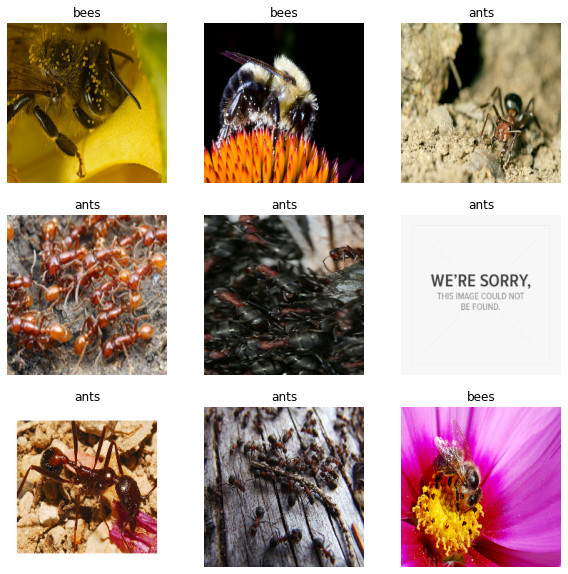

In [6]:
# Show the first nine images and labels from the training set

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Data Augmentation

Since we have very little training data it makes sense to use some data augmentation for training. This will help preventing overfitting by introducing image sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


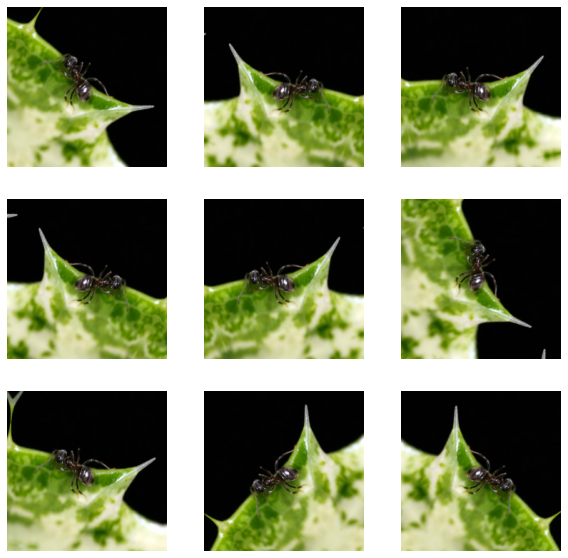

In [8]:
# Apply the data augmentation layers 9 times to the same image to see the results.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


## Initialize the ResNet model

We will use the [`Resnet50`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50) model, and set the `weights` parameter to `'imagenet'` to load the pre-trained weights on ImageNet. 

When we print the arquitecture of the model, we see that the last layer is a fully connected (`Dense`) layer with 1000 output neurons as shown below:


   `predictions (Dense)             (None, 1000)`

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               weights='imagenet')

print(base_model.summary())

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

By specifying the `include_top=False` and `pooling='avg'` arguments, we load a network that doesn't include the classification layer at the top, which is ideal for transfer learning.



In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')

print(base_model.summary())

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

Now the base model converts each 224x224x3 image into a 2048-d feature vector:

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 2048)


## Feature extraction

In this step, we will freeze the convolutional base created from the previous step to use it as a feature extractor. Then we will add a classification layer on top of it and train it using our training data.

In [12]:
# prevent the weights in a given layer from being updated during training
base_model.trainable = False


In [13]:
# add a classification layer 
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


(32, 1)


### Build the model

In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

### Compile the model

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [16]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Epoch 1/15
8/8 [==============================] - 8s 537ms/step - loss: 0.8767 - accuracy: 0.4637 - val_loss: 0.7305 - val_accuracy: 0.5359
Epoch 2/15
8/8 [==============================] - 2s 236ms/step - loss: 0.6976 - accuracy: 0.5712 - val_loss: 0.6840 - val_accuracy: 0.5752
Epoch 3/15
8/8 [==============================] - 2s 235ms/step - loss: 0.6994 - accuracy: 0.5843 - val_loss: 0.6415 - val_accuracy: 0.6144
Epoch 4/15
8/8 [==============================] - 2s 234ms/step - loss: 0.6467 - accuracy: 0.6222 - val_loss: 0.6021 - val_accuracy: 0.6275
Epoch 5/15
8/8 [==============================] - 2s 233ms/step - loss: 0.6033 - accuracy: 0.6631 - val_loss: 0.5661 - val_accuracy: 0.6405
Epoch 6/15
8/8 [==============================] - 2s 235ms/step - loss: 0.6106 - accuracy: 0.6314 - val_loss: 0.5333 - val_accuracy: 0.6667
Epoch 7/15
8/8 [==============================] - 2s 234ms/step - loss: 0.5898 - accuracy: 0.6201 - val_loss: 0.5039 - val_accuracy: 0.6797
Epoch 8/15
8/8 [====

Plot the learning curves:

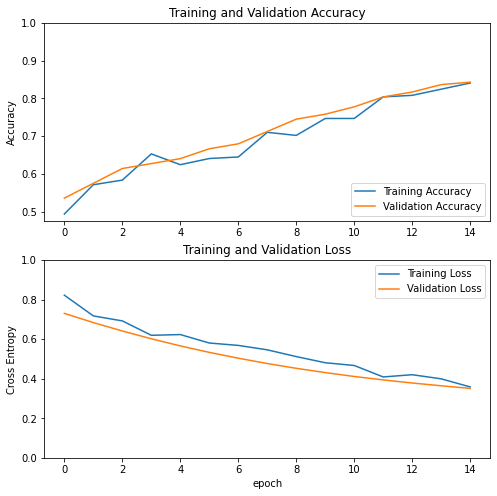

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Fine tuning

In the feature extraction experiment, we were only training the last `Dense` layer on top of a ResNet50 base model. The weights of the pre-trained network were **not** updated during training.

Now we will train again our model but updating all the weights at training time.

In [18]:
# Un-freeze the base model layers
base_model.trainable = True


In [19]:
# add a classification layer 
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


(32, 1)


### Build the model

In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

### Compile the model

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [22]:
history_ft = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Epoch 1/15
8/8 [==============================] - 12s 700ms/step - loss: 0.9964 - accuracy: 0.6095 - val_loss: 0.4658 - val_accuracy: 0.6732
Epoch 2/15
8/8 [==============================] - 4s 462ms/step - loss: 0.4090 - accuracy: 0.7835 - val_loss: 0.2334 - val_accuracy: 0.9085
Epoch 3/15
8/8 [==============================] - 4s 462ms/step - loss: 0.3232 - accuracy: 0.8673 - val_loss: 0.5917 - val_accuracy: 0.7778
Epoch 4/15
8/8 [==============================] - 4s 461ms/step - loss: 0.4067 - accuracy: 0.8214 - val_loss: 0.2818 - val_accuracy: 0.8758
Epoch 5/15
8/8 [==============================] - 4s 465ms/step - loss: 0.2583 - accuracy: 0.8823 - val_loss: 0.4432 - val_accuracy: 0.7386
Epoch 6/15
8/8 [==============================] - 4s 464ms/step - loss: 0.2818 - accuracy: 0.8931 - val_loss: 0.2867 - val_accuracy: 0.8627
Epoch 7/15
8/8 [==============================] - 4s 466ms/step - loss: 0.1499 - accuracy: 0.9491 - val_loss: 0.6868 - val_accuracy: 0.6536
Epoch 8/15
8/8 [===

Plot the learning curves and compare with the model trained with feature extraction:

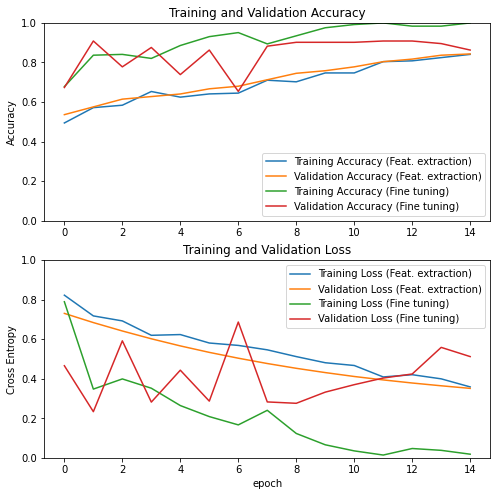

In [27]:
acc_ex = history.history['accuracy']
val_ex = history.history['val_accuracy']
loss_ex = history.history['loss']
val_loss_ex = history.history['val_loss']

acc_ex = history.history['accuracy']
val_acc_ex = history.history['val_accuracy']
loss_ft = history_ft.history['loss']
val_loss_ft = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_ex, label='Training Accuracy (Feat. extraction)')
plt.plot(val_acc_ex, label='Validation Accuracy (Feat. extraction)')
plt.plot(acc_ft, label='Training Accuracy (Fine tuning)')
plt.plot(val_acc_ft, label='Validation Accuracy (Fine tuning)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_ex, label='Training Loss (Feat. extraction)')
plt.plot(val_loss_ex, label='Validation Loss (Feat. extraction)')
plt.plot(loss_ft, label='Training Loss (Fine tuning)')
plt.plot(val_loss_ft, label='Validation Loss (Fine tuning)')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


We appreciate that while the final validation accuracy is quite similar in both models, the model trained with fine-tuning is more prone to overfitting. Which makes sense given the small size of the training dataset. Choosing one technique or another depends on many aspects, such as the model architecture, the size of the training data, and/or how similar are the source and target tasks.

### Additional References

- [Tensorflow transfer learning and fine-tuning guide](https://www.tensorflow.org/guide/keras/transfer_learning)
- [Transfer Learning page at the Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition.](https://cs231n.github.io/transfer-learning/)